In [15]:
# 라이브러리를 불러옵니다.
import numpy as np
import pandas as pd
from itertools import combinations
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import seaborn as sns

import networkx as nx

In [16]:
# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/MalgunGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=18)
rc('font', family='Malgun Gothic')

In [17]:
temp = pd.read_csv('data/antidepressant_prescription_2018.csv', nrows=5)
temp

기준년도  가입자일련번호  처방내역일련번호  일련번호  성별코드  연령대코드(5세단위)  시도코드    요양개시일자  \
0  2018        6  18208216     5     2           15    47  20180711   
1  2018        6  21251693     5     2           15    47  20180509   
2  2018        6  61477917     5     2           15    47  20180314   
3  2018        6  50755979     5     2           15    47  20180110   
4  2018        6  51543966     5     2           15    47  20180919   

   약품일반성분명코드  1회투약량  1일투약량  총투여일수     단가     금액   데이터공개일자  
0  495501ACE    1.0      2     35  402.0  28140  20191217  
1  495501ACE    1.0      2     35  402.0  28140  20191217  
2  495501ACE    1.0      2     56  402.0  45024  20191217  
3  495501ACE    1.0      2     28  404.0  22624  20191217  
4  495501ACE    1.0      2     56  402.0  45024  20191217

In [18]:
# 데이터를 불러옵니다.
# data = pd.read_csv('data/antidepressant_prescription_all_years.csv', encoding='utf-8')
data = pd.read_parquet('data/antidepressant_prescription_all_years.parquet')

ad_mapping = pd.read_csv('data/antidepressant_mapping_v2.csv', encoding='utf-8')

In [19]:
# 데이터의 첫 다섯 줄을 출력합니다.
print(data.shape)
data.head()

(1183768, 16)


기준년도  가입자일련번호  처방내역일련번호  일련번호  성별코드  연령대코드(5세단위)  시도코드     요양개시일자  \
0  2017       31  47455974     2     2           10    26 2017-03-23   
1  2017       56  36005918     2     2           11    30 2017-11-13   
2  2017       62   7819529     2     1           12    41 2017-07-11   
3  2017       62  35429246     2     1           12    41 2017-08-08   
4  2017       62  37765102     5     1           12    41 2017-06-09   

   약품일반성분명코드  1회 투약량  1일투약량  총투여일수     단가     금액   데이터 공개일자    ATC코드  
0  229601ATB     1.0      2     35  152.0  10640 2018-11-26  N06AX14  
1  229601ATB     1.0      3     14  158.0   6636 2018-11-26  N06AX14  
2  242901ATB     2.0      1     28   40.0   2240 2018-11-26  N06AX05  
3  242901ATB     2.0      1     28   40.0   2240 2018-11-26  N06AX05  
4  242901ATB     2.0      1     28   40.0   2240 2018-11-26  N06AX05

In [20]:
# 처방내역일련번호로 그룹화하여 처방된 약품의 개수를 세어봅니다.
pd.DataFrame(data.groupby('처방내역일련번호')['약품일반성분명코드'].count().value_counts()).T

약품일반성분명코드      1       2      3     4    5   6   7   8   9   12
count      836681  127866  23766  3978  706  87   8   2   1   1

### 약품일반성분명코드란?
**약품일반성분명코드** 또는 **주성분코드**는 의약품의 대표하는 성분에 대한 코드입니다. \
총 9자리로 구성되어 있으며 구성은 아래와 같습니다. 앞 4자리의 주성분 일련번호가 동일하면 동일한 성분으로 생각할 수 있습니다.

![주성분코드](img/주성분코드.png)

이후로는 Main Ingredient Code (MI_code)라고 지칭하도록 하겠습니다.

In [21]:
# 컬럼 이름들을 영문으로 바꿔줍니다
data.rename(columns={
    '기준년도': 'year',
    '가입자일련번호': 'user_id',
    '처방내역일련번호': 'pres_id',
    '일련번호': 'med_id',
    '성별코드': 'gender',
    '연령대코드(5세단위)': 'age_group',
    '시도코드': 'region',
    '요양개시일자': 'treatment_start_date',
    '약품일반성분명코드': 'mi_code',
    '1회 투약량': 'dose_per_time',
    '1일투약량': 'dose_per_day',
    '총투여일수': 'total_days',
    '단가': 'unit_price',
    '금액': 'total_price',
    '데이터 공개일자': 'data_release_date',
    'ATC코드': 'ATC_code'
}, inplace=True)

In [22]:
# 한 환자당 처방전의 개수를 세어봅니다.
data.groupby('user_id')['pres_id'].count().describe()

count    219817.000000
mean          5.385243
std           7.321897
min           1.000000
25%           1.000000
50%           3.000000
75%           6.000000
max         161.000000
Name: pres_id, dtype: float64

한 사람당 여러번의 처방전이 발부될 수 있고, 그 처방전들 중 같은 약을 포함하기도하고 다른 약을 포함하기도 한다는 것을 볼 수 있습니다.

두 종류의 약물이 같이 처방된 빈도 수를 계산할 때, 같은 사람에게 여러번 처방된 케이스는 같이 처방된 횟수로 나누어야 한다고 판단했습니다.

그렇지 않으면 한사람에게 여러번 처방된 약들이 weight에 불평등한 영향을 미칠 것으로 예상됩니다.

In [23]:
# 각 연도별 그래프를 생성하는 함수를 만듭니다.
def create_yearly_graph(data):
    yearly_graphs = {}
    
    # 연도별로 데이터를 그룹화합니다.
    for year, group in data.groupby('year'):
        G = nx.Graph()
        
        # 노드를 추가합니다.
        for atc_code in group['ATC_code'].unique():
            G.add_node(atc_code)

        # user_id와 pres_id로 그룹화하여 동시 발생을 찾습니다.
        user_cooccurrences = {}
        for user_id, user_group in group.groupby('user_id'):
            # 각 user_id에 대해 co-occurrence를 집합으로 저장합니다.
            cooccurrences = set()
            for pres_id, pres_group in user_group.groupby('pres_id'):
                atc_codes = pres_group['ATC_code'].unique()
                for i in range(len(atc_codes)):
                    for j in range(i + 1, len(atc_codes)):
                        cooccurrence = tuple(sorted((atc_codes[i], atc_codes[j])))
                        cooccurrences.add(cooccurrence)
            user_cooccurrences[user_id] = cooccurrences

        # co-occurrence를 그래프에 추가합니다.
        for cooccurrences in user_cooccurrences.values():
            for atc_code1, atc_code2 in cooccurrences:
                if G.has_edge(atc_code1, atc_code2):
                    G[atc_code1][atc_code2]['weight'] += 1
                else:
                    G.add_edge(atc_code1, atc_code2, weight=1)
                
        yearly_graphs[year] = G
    
    return yearly_graphs

## 그래프 시각화
이제 NetworkX를 통해 시각화를 해주도록 하겠습니다.

In [ ]:
# ATC 코드를 약품명으로 바꿔줍니다.
atc_to_name = ad_mapping.set_index('ATC_code')['ATC_name'].to_dict()

# 노드를 인덱스로 변환합니다 (색상을 입히기 위함)
encode_node = {node: idx for idx, node in enumerate(data['ATC_code'].unique())}

def draw_graph(G, year, layout):
    # 그래프를 그립니다.
    plt.figure(figsize=(10, 8))
    if layout == 'spring':
        pos = nx.spring_layout(G, seed=42)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    elif layout == 'circular':
        pos = nx.circular_layout(G)

    # 노드의 색상을 주성분 이름에 따라 설정합니다.
    node_color_by_abbrev = [encode_node[node] for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_color_by_abbrev, cmap=plt.cm.tab20)

    # 엣지의 투명도를 weight에 비례하게 설정합니다.
    max_weight = max([d['weight'] for u, v, d in G.edges(data=True)])
    for edge in G.edges(data="weight"):
        nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)

    # 인덱스를 이용한 노드 레이블링을 합니다.
    labels = {node: atc_to_name[node] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    plt.title(f'{year}년도 처방 데이터 네트워크')
    
    return plt

In [25]:
# 연도별 그래프를 생성합니다.
yearly_graphs = create_yearly_graph(data)

KeyboardInterrupt: 

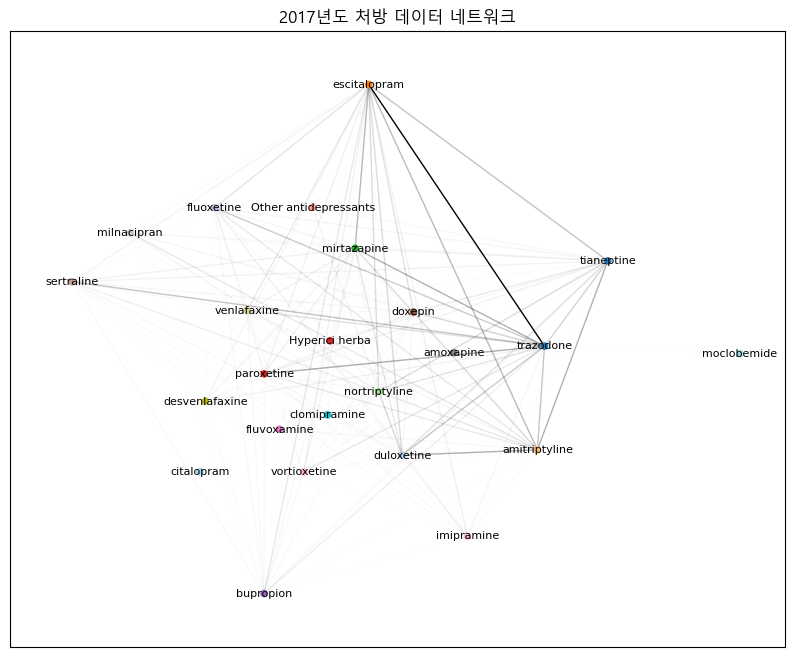

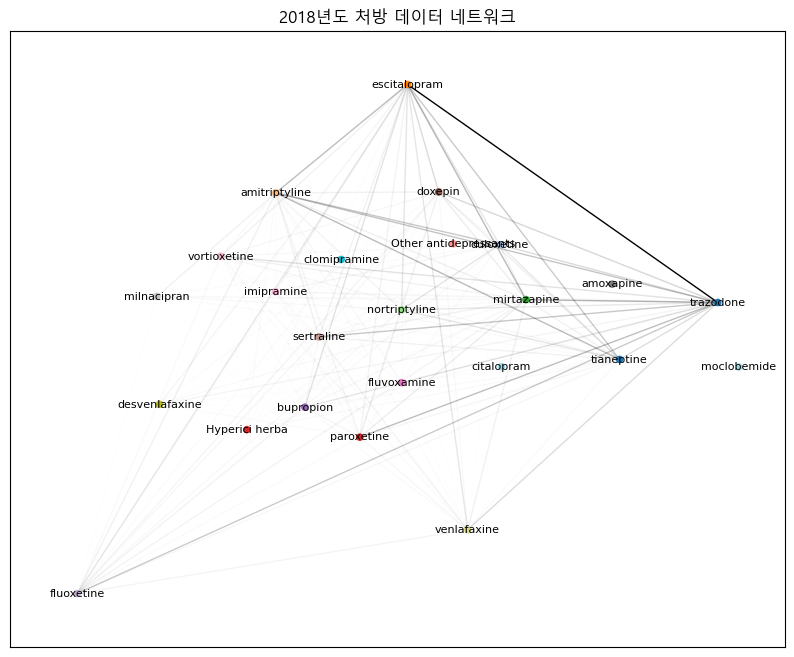

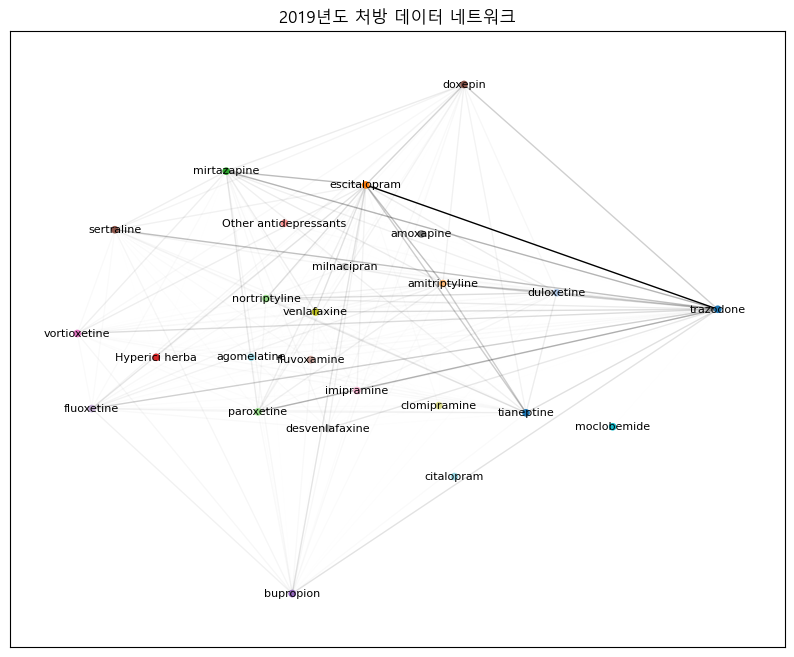

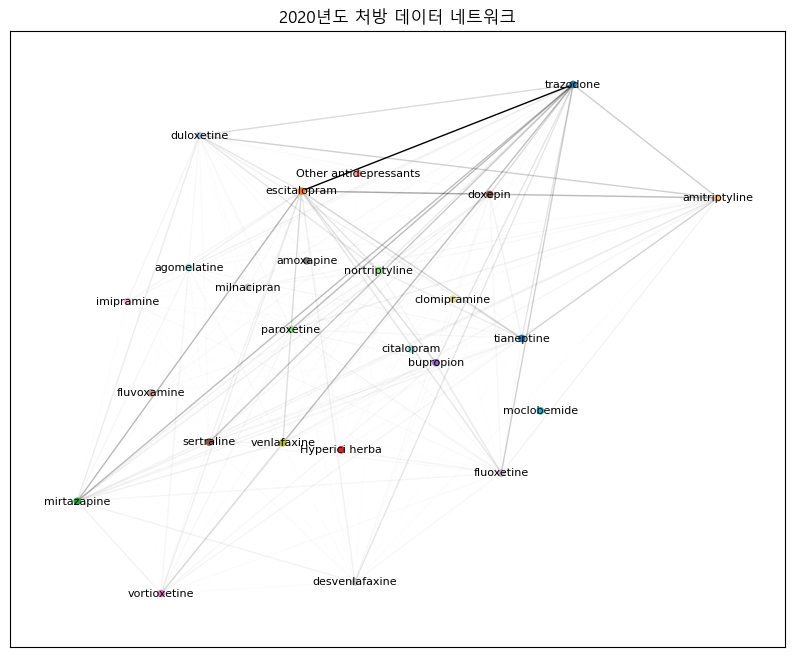

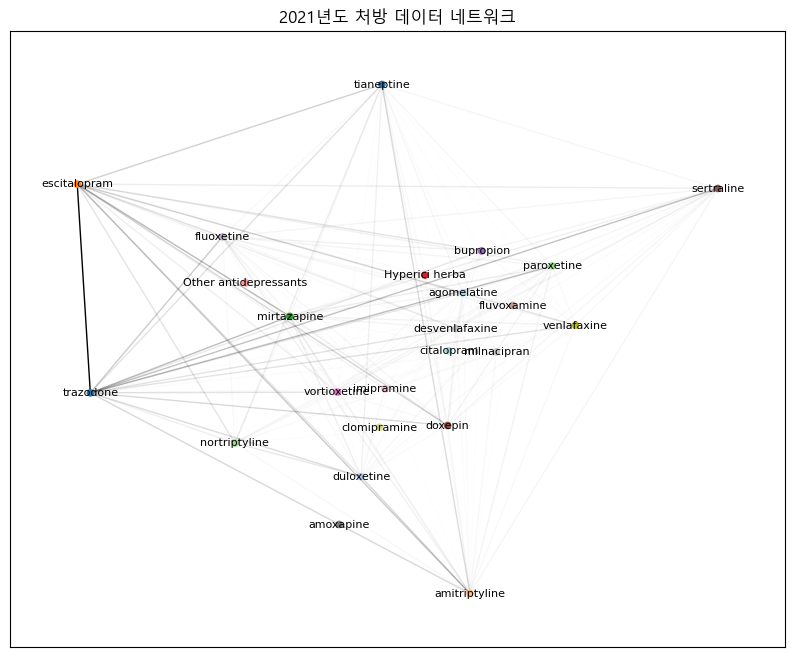

In [ ]:
# 2017~2021년까지의 그래프를 서브플롯으로 그립니다.
for idx, year in enumerate(range(2017, 2022)):
    G = yearly_graphs[year]
    draw_graph(G, year, 'kamada_kawai')
plt.show()

In [ ]:
# Calculate network density for each year
for year in range(2017, 2022):
    G = yearly_graphs[year]
    density = nx.density(G)
    print(f'{year}년도 네트워크 밀도: {density:.4f}')
    n_edges = G.number_of_edges()
    n_nodes = G.number_of_nodes()
    print(f'노드 수: {n_nodes}, 엣지 수: {n_edges}')

2017년도 네트워크 밀도: 0.6848
노드 수: 24, 엣지 수: 189
2018년도 네트워크 밀도: 0.6957
노드 수: 24, 엣지 수: 192
2019년도 네트워크 밀도: 0.7100
노드 수: 25, 엣지 수: 213
2020년도 네트워크 밀도: 0.6933
노드 수: 25, 엣지 수: 208
2021년도 네트워크 밀도: 0.7681
노드 수: 24, 엣지 수: 212


In [ ]:
# Gephi 파일로 추출합니다
for year, G in yearly_graphs.items():
    nx.write_gexf(G, f'data/gephi/antidepressant_prescription_{year}.gexf')

In [ ]:
(data.groupby('pid')['기준년도'].nunique() > 1).sum()

6712

---
---

## 다이나믹 시각화 (Gephi 사용)

In [ ]:
# New way:

# 1. Create a dataframe that has all the possible medicine pair in its rows and all days in its columns
# 2. If a patient is prescribed both medicines in a pair, increment the corresponding day by 1
# 3. Create a gefx file for all the years using the dataframe 
# 3a. The weight of the edge between two medicines is the value of the cell in the dataframe for that pair and day

# Part 1:
# Create a dataframe that has all the possible medicine pair in its rows and all days in its columns
# Get all the unique ATC codes
unique_codes = data['ATC_code'].unique()

# Create a dataframe with all the possible pairs
pairs = list(combinations(unique_codes, 2))
pair_df = pd.DataFrame(pairs, columns=['ATC_code1', 'ATC_code2'])

# Create a dataframe with all the possible pairs and days
pair_df = pd.DataFrame(pairs, columns=['ATC_code1', 'ATC_code2'])

# date goes from 2017-01-01 to 2021-12-31
date_range = pd.date_range(start='2017-01-01', end='2021-12-31')
date_range = date_range.strftime('%Y-%m-%d')
pair_df = pd.concat([pair_df, pd.DataFrame(columns=date_range)], axis=1)
pair_df

ATC_code1 ATC_code2 2017-01-01 2017-01-02 2017-01-03 2017-01-04  \
0     N06AX14   N06AX05        NaN        NaN        NaN        NaN   
1     N06AX14   N06AX21        NaN        NaN        NaN        NaN   
2     N06AX14   N06AB10        NaN        NaN        NaN        NaN   
3     N06AX14   N06AA09        NaN        NaN        NaN        NaN   
4     N06AX14   N06AX11        NaN        NaN        NaN        NaN   
..        ...       ...        ...        ...        ...        ...   
295   N06AA04   N06AB04        NaN        NaN        NaN        NaN   
296   N06AA04   N06AX22        NaN        NaN        NaN        NaN   
297   N06AG02   N06AB04        NaN        NaN        NaN        NaN   
298   N06AG02   N06AX22        NaN        NaN        NaN        NaN   
299   N06AB04   N06AX22        NaN        NaN        NaN        NaN   

    2017-01-05 2017-01-06 2017-01-07 2017-01-08  ... 2021-12-22 2021-12-23  \
0          NaN        NaN        NaN        NaN  ...        NaN        NaN   
1          NaN        NaN        NaN        NaN  ...        NaN        NaN   
2          NaN        NaN        NaN        NaN  ...        NaN        NaN   
3          NaN        NaN        NaN        NaN  ...        NaN        NaN   
4          NaN        NaN        NaN        NaN  ...        NaN        NaN   
..         ...        ...        ...        ...  ...        ...        ...   
295        NaN        NaN        NaN        NaN  ...        NaN        NaN   
296        NaN        NaN        NaN        NaN  ...        NaN        NaN   
297        NaN        NaN        NaN        NaN  ...        NaN        NaN   
298        NaN        NaN        NaN        NaN  ...        NaN        NaN   
299        NaN        NaN        NaN        NaN  ...        NaN        NaN   

    2021-12-24 2021-12-25 2021-12-26 2021-12-27 2021-12-28 2021-12-29  \
0          NaN        NaN        NaN        NaN        NaN        NaN   
1          NaN        NaN        NaN        NaN        NaN        NaN   
2          NaN        NaN        NaN        NaN        NaN        NaN   
3          NaN        NaN        NaN        NaN        NaN        NaN   
4          NaN        NaN        NaN        NaN        NaN        NaN   
..         ...        ...        ...        ...        ...        ...   
295        NaN        NaN        NaN        NaN        NaN        NaN   
296        NaN        NaN        NaN        NaN        NaN        NaN   
297        NaN        NaN        NaN        NaN        NaN        NaN   
298        NaN        NaN        NaN        NaN        NaN        NaN   
299        NaN        NaN        NaN        NaN        NaN        NaN   

    2021-12-30 2021-12-31  
0          NaN        NaN  
1          NaN        NaN  
2          NaN        NaN  
3          NaN        NaN  
4          NaN        NaN  
..         ...        ...  
295        NaN        NaN  
296        NaN        NaN  
297        NaN        NaN  
298        NaN        NaN  
299        NaN        NaN  

[300 rows x 1828 columns]

In [ ]:
pair_df.loc[:, '2019-06-18']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
295    NaN
296    NaN
297    NaN
298    NaN
299    NaN
Name: 2019-06-18, Length: 300, dtype: object

In [ ]:
# Part 2:
# If a patient is prescribed both medicines in a pair, increment the corresponding day by 1

# Create a dictionary to store the counts
pair_counts = {}

# Group by user_id and pres_id
for user_id, user_group in data.groupby('user_id'):
    for pres_id, pres_group in user_group.groupby('pres_id'):
        atc_codes = pres_group['ATC_code'].unique()
        if len(atc_codes) > 1:
            start_date = pres_group['treatment_start_date'].min()
            end_date = min(pd.to_datetime(start_date) + pd.Timedelta(days=pres_group['total_days'].max()), pd.to_datetime('2021-12-31'))
            date_range = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m-%d')
            
            for atc_code1, atc_code2 in combinations(atc_codes, 2):
                pair = tuple(sorted((atc_code1, atc_code2)))
                if pair not in pair_counts:
                    pair_counts[pair] = {date: 0 for date in date_range}
                for date in date_range:
                    if date not in pair_counts[pair]:
                        pair_counts[pair][date] = 0
                    pair_counts[pair][date] += 1

KeyError: 'index'

In [26]:
pair_counts

{('N06AB05', 'N06AB10'): {'2019-07-30': 18,
  '2019-07-31': 16,
  '2019-08-01': 14,
  '2019-08-02': 16,
  '2019-08-03': 16,
  '2019-08-04': 16,
  '2019-08-05': 18,
  '2019-08-06': 19,
  '2019-08-07': 19,
  '2019-08-08': 18,
  '2019-08-09': 18,
  '2019-08-10': 19,
  '2019-08-11': 19,
  '2019-08-12': 19,
  '2019-08-13': 20,
  '2019-06-18': 18,
  '2019-06-19': 19,
  '2019-06-20': 20,
  '2019-06-21': 22,
  '2019-06-22': 23,
  '2019-06-23': 22,
  '2019-06-24': 22,
  '2019-06-25': 22,
  '2019-06-26': 21,
  '2019-06-27': 20,
  '2019-06-28': 21,
  '2019-06-29': 21,
  '2019-06-30': 21,
  '2019-07-01': 22,
  '2019-07-02': 23,
  '2019-07-03': 25,
  '2019-07-04': 23,
  '2019-07-05': 22,
  '2019-07-06': 22,
  '2019-07-07': 22,
  '2019-07-08': 22,
  '2019-07-09': 23,
  '2019-04-23': 20,
  '2019-04-24': 17,
  '2019-04-25': 18,
  '2019-04-26': 17,
  '2019-04-27': 17,
  '2019-04-28': 17,
  '2019-04-29': 17,
  '2019-04-30': 19,
  '2019-05-01': 18,
  '2019-05-02': 18,
  '2019-05-03': 19,
  '2019-05-04': 

In [40]:
# Convert the dictionary to a DataFrame
pair_df = pd.DataFrame.from_dict(pair_counts, orient='index').reset_index()
# pair_df[['ATC_code1', 'ATC_code2']] = pd.DataFrame(pair_df['index'].tolist(), index=pair_df.index)
# pair_df.drop(columns=['index'], inplace=True)
pair_df.rename(columns={'level_0': 'ATC_code1', 'level_1': 'ATC_code2'}, inplace=True)

# Sort columns by date
pair_df = pair_df.reindex(sorted(pair_df.columns), axis=1)

# Replace NaN with 0
pair_df.fillna(0, inplace=True)

In [42]:
pair_df

2017-01-02  2017-01-03  2017-01-04  2017-01-05  2017-01-06  2017-01-07  \
0           0.0         0.0         0.0         0.0         2.0         3.0   
1           0.0         0.0         0.0         2.0         2.0         3.0   
2           0.0         0.0         0.0         0.0         1.0         2.0   
3           2.0         4.0         4.0         7.0         8.0        10.0   
4           0.0         0.0         0.0         0.0         0.0         0.0   
..          ...         ...         ...         ...         ...         ...   
232         0.0         0.0         0.0         0.0         0.0         0.0   
233         0.0         0.0         0.0         0.0         0.0         0.0   
234         0.0         0.0         0.0         0.0         0.0         0.0   
235         0.0         0.0         0.0         0.0         0.0         0.0   
236         0.0         0.0         0.0         0.0         0.0         0.0   

     2017-01-08  2017-01-09  2017-01-10  2017-01-11  ...  2021-12-24  \
0           3.0         4.0         4.0         5.0  ...        19.0   
1           3.0         3.0         4.0         4.0  ...        92.0   
2           2.0         3.0         3.0         3.0  ...        20.0   
3          10.0        13.0        20.0        23.0  ...       142.0   
4           0.0         0.0         1.0         1.0  ...         6.0   
..          ...         ...         ...         ...  ...         ...   
232         0.0         0.0         0.0         0.0  ...         0.0   
233         0.0         0.0         0.0         0.0  ...         0.0   
234         0.0         0.0         0.0         0.0  ...         0.0   
235         0.0         0.0         0.0         0.0  ...         0.0   
236         0.0         0.0         0.0         0.0  ...         0.0   

     2021-12-25  2021-12-26  2021-12-27  2021-12-28  2021-12-29  2021-12-30  \
0          19.0        19.0        19.0        19.0        18.0        18.0   
1          90.0        90.0        94.0        95.0        94.0        91.0   
2          20.0        20.0        20.0        22.0        21.0        21.0   
3         134.0       132.0       139.0       143.0       142.0       146.0   
4           6.0         6.0         6.0         6.0         6.0         6.0   
..          ...         ...         ...         ...         ...         ...   
232         0.0         0.0         0.0         0.0         0.0         0.0   
233         0.0         0.0         0.0         0.0         0.0         0.0   
234         0.0         0.0         0.0         0.0         0.0         0.0   
235         0.0         0.0         0.0         0.0         0.0         0.0   
236         0.0         0.0         0.0         0.0         0.0         0.0   

     2021-12-31  ATC_code1  ATC_code2  
0          19.0    N06AB05    N06AB10  
1          90.0    N06AA12    N06AX05  
2          21.0    N06AA12    N06AB06  
3         142.0    N06AB06    N06AX05  
4           5.0    N06AA09    N06AB08  
..          ...        ...        ...  
232         0.0    N06AB05      N06AX  
233         0.0    N06AA12    N06AA17  
234         0.0    N06AA17      N06AX  
235         0.0    N06AA04    N06AX14  
236         0.0    N06AB03    N06AG02  

[237 rows x 1827 columns]

In [ ]:
# Temporary save
pair_df.to_csv('data/gephi/pair_df.csv', index=False)

# Read
pair_df = pd.read_csv('data/gephi/pair_df.csv')

In [38]:
# Part 3:
# Create a gefx file for all the years using the dataframe
def create_dynamic_gexf(pair_df):
    G = nx.Graph()

    # Add all nodes
    for atc_code in pair_df['ATC_code1'].unique():
        G.add_node(atc_code, label=atc_to_name[atc_code], start="2017-01-01", end="2021-12-31")

    # Add all edges
    for idx, row in pair_df.iterrows():
        for date in date_range:
            if row[date] > 0:
                G.add_edge(row['ATC_code1'], row['ATC_code2'], 
                           interval=f'[{date}/{date}]',
                           weight=row[date])

    output_file = 'data/gephi/antidepressant_prescription_dynamic.gexf'
    nx.write_gexf(G, output_file)
    print(f'Gephi file saved to {output_file}')

    return G

G = create_dynamic_gexf(pair_df)

Gephi file saved to data/gephi/antidepressant_prescription_dynamic.gexf


In [44]:
def create_dynamic_gexf(pair_df):
    G = nx.Graph()

    # Add all nodes
    for atc_code in pd.concat([pair_df['ATC_code1'], pair_df['ATC_code2']]).unique():
        G.add_node(atc_code, label=atc_to_name.get(atc_code, atc_code), start="2017-01-01", end="2021-12-31")

    # Add all edges
    for idx, row in pair_df.iterrows():
        for date in row.index[:-2]:  # Skip the last two columns (ATC_code1 and ATC_code2)
            if row[date] > 0:
                if G.has_edge(row['ATC_code1'], row['ATC_code2']):
                    edge_data = G[row['ATC_code1']][row['ATC_code2']]
                    edge_data['interval'] += f',{date}/{date}'
                    edge_data['weights'].append((date, row[date]))
                else:
                    G.add_edge(row['ATC_code1'], row['ATC_code2'], 
                               interval=f'[{date}/{date}]',
                               weights=[(date, row[date])])

    # Adjust weights dynamically
    for u, v, data in G.edges(data=True):
        intervals = data['interval'].split(',')
        weights = data['weights']
        dynamic_weights = []
        current_weight = 0

        for interval, (date, weight) in zip(intervals, weights):
            current_weight += weight
            dynamic_weights.append((interval, current_weight))

        data['weight'] = dynamic_weights

    return G

G = create_dynamic_gexf(pair_df)

In [46]:
# Write to GEXF
output_file = 'data/gephi/antidepressant_prescription_dynamic.gexf'
nx.write_gexf(G, output_file)
print(f'Gephi file saved to {output_file}')

ValueError: not enough values to unpack (expected 3, got 2)

In [17]:
from datetime import timedelta

def create_dynamic_graph_with_weights(data):
    # 모든 날짜를 포함하는 네트워크 딕셔너리
    dynamic_graphs = {}

    # 데이터 전처리: 날짜 형식 변환
    data['start_date'] = pd.to_datetime(data['treatment_start_date'])
    data['end_date'] = data['start_date'] + pd.to_timedelta(data['total_days'], unit='D')

    # 연도별로 데이터를 그룹화
    for year, group in data.groupby('year'):
        G = nx.Graph()
        
        # 노드 추가
        for atc_code in group['ATC_code'].unique():
            G.add_node(atc_code)

        # Edge 업데이트를 위한 날짜별 가중치 변화 저장
        edge_changes = {}

        # 처방 데이터를 기반으로 날짜별 weight 변화 기록
        for user_id, user_group in group.groupby('user_id'):
            for pres_id, pres_group in user_group.groupby('pres_id'):
                atc_codes = pres_group['ATC_code'].unique()
                start_date = pres_group['start_date'].min()
                end_date = pres_group['end_date'].max()

                for i in range(len(atc_codes)):
                    for j in range(i + 1, len(atc_codes)):
                        atc_pair = tuple(sorted((atc_codes[i], atc_codes[j])))

                        # Edge가 존재하지 않으면 생성
                        if atc_pair not in edge_changes:
                            edge_changes[atc_pair] = {}

                        # 날짜별로 weight 업데이트
                        current_date = start_date
                        while current_date <= end_date:
                            if current_date not in edge_changes[atc_pair]:
                                edge_changes[atc_pair][current_date] = 0
                            edge_changes[atc_pair][current_date] += 1
                            current_date += timedelta(days=1)

        # 날짜별 네트워크 생성
        all_dates = set()
        for edge, changes in edge_changes.items():
            all_dates.update(changes.keys())

        for date in sorted(all_dates):
            if date not in dynamic_graphs:
                dynamic_graphs[date] = nx.Graph()

            for edge, changes in edge_changes.items():
                if date in changes:
                    weight = changes[date]

                    # 그래프에 Edge 추가 또는 업데이트
                    if dynamic_graphs[date].has_edge(*edge):
                        dynamic_graphs[date][edge[0]][edge[1]]['weight'] += weight
                    else:
                        dynamic_graphs[date].add_edge(edge[0], edge[1], weight=weight)

    return dynamic_graphs


In [18]:
dynamic_graphs = create_dynamic_graph_with_weights(data[data['year'] == 2017])

C:\Users\YuHan\AppData\Local\Temp\ipykernel_15516\3527689761.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['start_date'] = pd.to_datetime(data['treatment_start_date'])
C:\Users\YuHan\AppData\Local\Temp\ipykernel_15516\3527689761.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['end_date'] = data['start_date'] + pd.to_timedelta(data['total_days'], unit='D')


In [15]:
def export_to_gephi(dynamic_graphs, output_dir):
    for date, graph in dynamic_graphs.items():
        date_str = date.strftime('%Y-%m-%d')

        # 노드 파일 생성
        nodes_df = pd.DataFrame({'Id': list(graph.nodes())})
        nodes_df.to_csv(f'{output_dir}/nodes_{date_str}.csv', index=False)

        # 엣지 파일 생성
        edges = []
        for u, v, data in graph.edges(data=True):
            edges.append({'Source': u, 'Target': v, 'Weight': data['weight']})
        edges_df = pd.DataFrame(edges)
        edges_df.to_csv(f'{output_dir}/edges_{date_str}.csv', index=False)


In [20]:
export_to_gephi(dynamic_graphs, 'data/gephi')

In [ ]:
# 에지를 추가하는 함수를 정의합니다.
def add_edges(G, data, min_support=0.01, min_lift=1):
    # 처방전의 개수를 세어봅니다.
    pid_count = data['pid'].nunique()
    
    # 처방전의 조합을 생성합니다.
    for i, (pid1, pid2) in enumerate(combinations(data['pid'].unique(), 2)):
        # 처방전의 조합이 존재하는 환자를 찾습니다.
        uid1 = data[data['pid'] == pid1]['uid'].values[0]
        uid2 = data[data['pid'] == pid2]['uid'].values[0]
        
        # 처방전의 조합이 존재하는 환자의 수를 세어봅니다.
        support = len(set(data[data['uid'] == uid1]['pid']) & set(data[data['uid'] == uid2]['pid'])) / pid_count
        
        # 처방전의 조합이 존재하는 환자의 처방전의 수를 세어봅니다.
        lift = support / (data[data['pid'] == pid1]['uid'].nunique() * data[data['pid'] == pid2]['uid'].nunique() / pid_count)
        
        # 지지도와 신뢰도가 기준값을 넘는 경우에만 그래프에 추가합니다.
        if support >= min_support and lift >= min_lift:
            G.add_edge(pid1, pid2, support=support, lift=lift)

In [20]:
df_year = data[data['기준년도'] == 2017]

# 1월 1일 부터 1월 31일까지의 데이터
df_month = df_year[(df_year['요양개시일자'] >= pd.to_datetime(20170101, format='%Y%m%d')) & (df_year['요양개시일자'] <= pd.to_datetime(pd.to_datetime(20170131, format='%Y%m%d')))]
df_month

기준년도  가입자일련번호  처방내역일련번호  일련번호  성별코드  연령대코드(5세단위)  시도코드     요양개시일자  \
41      2017      357    147908     2     1           13    28 2017-01-14   
51      2017      360  24830429     5     1           15    27 2017-01-20   
101     2017      534  58641745     4     2           11    44 2017-01-02   
102     2017      534  58641745     5     2           11    44 2017-01-02   
124     2017      717  46886174     3     2           18    11 2017-01-13   
...      ...      ...       ...   ...   ...          ...   ...        ...   
205648  2017   999871   4034663     1     2           14    27 2017-01-24   
205649  2017   999871   4034663     5     2           14    27 2017-01-24   
205662  2017   999871  58855852     1     2           14    27 2017-01-02   
205663  2017   999871  58855852     5     2           14    27 2017-01-02   
205681  2017   999981  30271025     5     2           16    44 2017-01-10   

        약품일반성분명코드  1회 투약량  1일투약량  총투여일수     단가     금액   데이터 공개일자    ATC코드  
41      229601ATB     1.0      2     30  158.0   9480 2018-11-26  N06AX14  
51      107501ATB     1.0      2     30   20.0   1200 2018-11-26  N06AA09  
101     107501ATB     1.0      2     30   20.0   1200 2018-11-26  N06AA09  
102     495501ACE     1.0      1     30  404.0  12120 2018-11-26  N06AX21  
124     161502ACH     1.0      2     90  472.0  84960 2018-11-26  N06AB03  
...           ...     ...    ...    ...    ...    ...        ...      ...  
205648  495501ACE     1.0      1     30  404.0  12120 2018-11-26  N06AX21  
205649  107501ATB     0.5      2     15   20.0    300 2018-11-26  N06AA09  
205662  495501ACE     1.0      1     30  404.0  12120 2018-11-26  N06AX21  
205663  107501ATB     0.5      2     15   20.0    300 2018-11-26  N06AA09  
205681  229601ATB     1.0      2     30  158.0   9480 2018-11-26  N06AX14  

[16195 rows x 16 columns]

In [23]:
data[data['총투여일수'] == 30]

기준년도  가입자일련번호  처방내역일련번호  일련번호  성별코드  연령대코드(5세단위)  시도코드     요양개시일자  \
6        2017      107  21130660     1     1           11    47 2017-10-17   
7        2017      107  49692667     1     1           11    47 2017-11-16   
21       2017      184  25060663     2     1           15    29 2017-07-24   
22       2017      184  25060663     5     1           15    29 2017-07-24   
23       2017      184  45064342     2     1           15    29 2017-06-21   
...       ...      ...       ...   ...   ...          ...   ...        ...   
1183730  2021   239692   9831876     2     2           15    41 2021-08-07   
1183733  2021   402561  10065818     2     2           13    28 2021-08-21   
1183737  2021   336637  10389108     2     2           17    41 2021-08-21   
1183741  2021   783789  10874455     2     2           18    46 2021-01-02   
1183763  2021   362319   8537598     1     1            8    41 2021-05-05   

         약품일반성분명코드  1회 투약량  1일투약량  총투여일수     단가     금액   데이터 공개일자    ATC코드  
6        495501ACE     1.0      1     30  404.0  12120 2018-11-26  N06AX21  
7        495501ACE     1.0      1     30  404.0  12120 2018-11-26  N06AX21  
21       107501ATB     0.5      1     30   23.0    345 2018-11-26  N06AA09  
22       196201ATB     1.0      1     30  764.0  22920 2018-11-26  N06AX11  
23       196201ATB     1.0      1     30  764.0  22920 2018-11-26  N06AX11  
...            ...     ...    ...    ...    ...    ...        ...      ...  
1183730  474802ATB     0.5      2     30  425.0  12750 2022-08-11  N06AB10  
1183733  172601ATB     1.5      2     30  159.0  14310 2022-08-11  N06AX25  
1183737  209302ATB     0.5      1     30  716.0  10740 2022-08-11  N06AB05  
1183741  474802ATB     0.5      1     30  616.0   9240 2022-08-11  N06AB10  
1183763  161502ACH     3.0      1     30  483.0  43470 2022-08-11  N06AB03  

[187727 rows x 16 columns]

In [18]:
pd.to_datetime(20170101, format='%Y%m%d')

Timestamp('2017-01-01 00:00:00')

In [ ]:
df_year = data[data['기준년도'] == 2017]

G = nx.Graph()

# 1. 모든 고유 노드 추출
all_nodes = df_year['mi_code'].unique()

# 2. 노드 추가
G.add_nodes_from(all_nodes,
                 start='2017-01-01',
                 end='2017-12-31')

# 3. 월별 데이터 분할
for month, group in df_year.groupby('기준월'):
    # 한 달에 처방된 약품의 조합을 구합니다.
    for node1, node2 in combinations(group['mi_code'].unique(), 2):
        if G.has_edge(node1, node2):
            G[node1][node2]['weight'] += 1
        else:
            G.add_edge(node1, node2, weight=1)

# 4. 엣지 추가


for month, group in df_year.groupby('기준월'):
    # 한 달에 처방된 약품의 조합을 구합니다.
    for node1, node2 in combinations(group['mi_code'].unique(), 2):
        if G.has_edge(node1, node2):
            G[node1][node2]['weight'] += 1
        else:
            G.add_edge(node1, node2, weight=1)

In [ ]:
def create_dynamic_gexf(df_year, node_col='mi_code'):
    G = nx.Graph()

    # 1. 모든 고유 노드 추출
    all_nodes = df_year[node_col].unique()
    
    # 3. 노드 추가 (시간 속성 포함)
    for node in all_nodes:
        G.add_node(node, 
                  label=str(node),  # 라벨을 문자열로 확실히 변환
                  start='2021-01-01T00:00:00.000',  # 밀리초 단위 추가
                  end='2021-12-31T23:59:59.000')    # 밀리초 단위 추가
    
    # 4. 엣지 추가 (가중치 계산 및 시간 속성 포함)
    for month, df in monthly_dfs.items():
        # pid 기준으로 그룹화
        grouped = df.groupby('pid')
        
        for pid, group in grouped:
            # 같은 pid 내의 약품들 간 엣지 생성
            drugs = group['mi_code'].unique()
            for i in range(len(drugs)):
                for j in range(i + 1, len(drugs)):
                    source = str(drugs[i])  # 문자열로 변환
                    target = str(drugs[j])
                    
                    # 가중치 계산 (float으로 확실하게 변환)
                    weight = float(1.0)  # 또는 다른 가중치 계산 방식 사용
                    
                    # 시간 정보 가져오기
                    timestamp = group['RECU_FR_DT'].iloc[0]
                    
                    # 엣지 추가
                    if not G.has_edge(source, target):
                        G.add_edge(source, target, 
                                 weight=weight,
                                 start=timestamp,
                                 end='2021-12-31T23:59:59.000')
                    else:
                        # 기존 엣지의 가중치 업데이트
                        current_weight = G[source][target]['weight']
                        G[source][target]['weight'] = float(current_weight + weight)
                        
    # 4. Degree centrality 계산
    degree_centrality = nx.degree_centrality(G)
    
    # 5. 노드 크기 계산 및 노드 추가
    max_size = 100  # 최대 노드 크기
    min_size = 10   # 최소 노드 크기
    
    for node in all_nodes:
        size = min_size + (degree_centrality[node] * (max_size - min_size))
        G.add_node(node, 
                   label=str(node),
                   start='2021-01-01T00:00:00.000',
                   end='2021-12-31T23:59:59.000',
                   size=size)  # 노드 크기 추가
    
    # 5. GEXF 파일 저장
    nx.write_gexf(G, '2021_dynamic_drug_network(1).gexf', version='1.2draft')
    
    return G

In [ ]:
def create_dynamic_gexf(monthly_dfs):
    G = nx.Graph()
    
    # 1. 노드 ID 표준화 및 시간 형식 수정
    for df in monthly_dfs.values():
        # mi_code를 문자열로 변환하고 공백 제거
        df['mi_code'] = df['mi_code'].astype(str).str.strip()
        # 날짜 형식 변환
        df['RECU_FR_DT'] = pd.to_datetime(df['RECU_FR_DT']).dt.strftime('%Y-%m-%dT00:00:00.000')
    
    # 2. 모든 고유 노드 추출
    all_nodes = set()
    for df in monthly_dfs.values():
        all_nodes.update(set(df['mi_code']))
    
    # 3. 노드 추가 (시간 속성 포함)
    for node in all_nodes:
        G.add_node(node, 
                  label=str(node),  # 라벨을 문자열로 확실히 변환
                  start='2021-01-01T00:00:00.000',  # 밀리초 단위 추가
                  end='2021-12-31T23:59:59.000')    # 밀리초 단위 추가
    
    # 4. 엣지 추가 (가중치 계산 및 시간 속성 포함)
    for month, df in monthly_dfs.items():
        # pid 기준으로 그룹화
        grouped = df.groupby('pid')
        
        for pid, group in grouped:
            # 같은 pid 내의 약품들 간 엣지 생성
            drugs = group['mi_code'].unique()
            for i in range(len(drugs)):
                for j in range(i + 1, len(drugs)):
                    source = str(drugs[i])  # 문자열로 변환
                    target = str(drugs[j])
                    
                    # 가중치 계산 (float으로 확실하게 변환)
                    weight = float(1.0)  # 또는 다른 가중치 계산 방식 사용
                    
                    # 시간 정보 가져오기
                    timestamp = group['RECU_FR_DT'].iloc[0]
                    
                    # 엣지 추가
                    if not G.has_edge(source, target):
                        G.add_edge(source, target, 
                                 weight=weight,
                                 start=timestamp,
                                 end='2021-12-31T23:59:59.000')
                    else:
                        # 기존 엣지의 가중치 업데이트
                        current_weight = G[source][target]['weight']
                        G[source][target]['weight'] = float(current_weight + weight)
                        
    # 4. Degree centrality 계산
    degree_centrality = nx.degree_centrality(G)
    
    # 5. 노드 크기 계산 및 노드 추가
    max_size = 100  # 최대 노드 크기
    min_size = 10   # 최소 노드 크기
    
    for node in all_nodes:
        size = min_size + (degree_centrality[node] * (max_size - min_size))
        G.add_node(node, 
                   label=str(node),
                   start='2021-01-01T00:00:00.000',
                   end='2021-12-31T23:59:59.000',
                   size=size)  # 노드 크기 추가
    
    # 5. GEXF 파일 저장
    nx.write_gexf(G, '2021_dynamic_drug_network(1).gexf', version='1.2draft')
    
    return G

In [ ]:
# 실행
# monthly_dfs 딕셔너리 생성 (1월부터 12월까지의 데이터프레임)
monthly_dfs = {
    1: df_1,
    2: df_2,
    # ... 나머지 월 데이터
    12: df_12
}

G = create_dynamic_gexf(monthly_dfs)

In [ ]:
def process_patient_data(patient_groups, med_col='mi_code', self_loop=False):
    # 페어 카운트를 저장할 Counter 초기화
    pair_counts = Counter()
    
    for patient_id, group in patient_groups:
        # 해당 환자의 모든 처방 가져오기
        prescriptions = group.groupby('pid')[med_col].apply(list)
        
        # 해당 환자의 유니크 약물 주성분 페어와 자기 자신 루프를 저장할 집합
        patient_pairs = set()
        patient_self_loops = set()
        
        # 해당 환자에게 처방된 모든 유니크 약물 주성분 페어와 자기 자신 루프 수집
        for meds in prescriptions:
            # 한 번 이상 나타나는 약물 주성분 식별 (self-loop)
            if self_loop:
                # 처방 내 각 약물 주성분의 발생 횟수 계산
                med_counts = Counter(meds)
                
                for med, count in med_counts.items():
                    if count > 1:
                        patient_self_loops.add(med)
            
            # 페어 조합을 위한 처방 내 유니크 약물 주성분 가져오기
            unique_meds_in_prescription = set(meds)
            pairs = combinations(unique_meds_in_prescription, 2)
            patient_pairs.update(pairs)
        
        # 해당 환자의 유니크 페어를 글로벌 페어 카운트에 업데이트
        pair_counts.update(patient_pairs)
        
        # 자기 자신 루프를 글로벌 페어 카운트에 업데이트
        if self_loop:
            for med in patient_self_loops:
                pair_counts[(med, med)] += 1

    return pair_counts

Adjacency matrix를 만드는 함수를 정의합니다.

- 대각선을 기준으로 대칭
- 같은 성분의 약물이 중복적으로 처방될 경우를 고려 (self-loop)

In [8]:
def build_adjacency_matrix(pair_counts, med_to_index):
    # 페어 카운트를 사용하여 인접 행렬 채우기
    adj_matrix = np.zeros((len(med_to_index), len(med_to_index)))
    
    for (med1, med2), count in pair_counts.items():
        idx1 = med_to_index[med1]
        idx2 = med_to_index[med2]
        adj_matrix[idx1][idx2] = count
        if med1 != med2:
            adj_matrix[idx2][idx1] = count  # 대칭 페어의 경우
        else:
            adj_matrix[idx1][idx2] = count  # 자기 자신 루프 (대각선 요소)
    
    return adj_matrix

시험용 테스트 데이터를 만들어 함수들이 제대로 작동하는 지 확인해 보겠습니다.

In [9]:
# 테스트 데이터프레임 생성
test_data = {
    "uid": [1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3], 
    "pid": [101, 101, 101, 201, 201, 202, 202, 202, 301, 301, 301], 
    "mi_code": [1, 2, 3, 2, 1, 1, 2, 3, 1, 1, 1] 
}
df_test = pd.DataFrame(test_data)

# 약품 코드를 인덱스로 매핑
unique_meds = df_test["mi_code"].unique()
med_to_index = {med: idx for idx, med in enumerate(unique_meds)}

# 환자별 그룹화
patient_groups = df_test.groupby('uid')

# 페어 카운트 처리
pair_counts = process_patient_data(patient_groups)

# 인접 행렬 생성
adj_matrix = build_adjacency_matrix(pair_counts, med_to_index)

# 결과 인접 행렬이 올바른지 확인
expected_adj_matrix = np.array([[1., 2., 2.], [2., 0., 2.], [2., 2., 0.]])
assert np.array_equal(adj_matrix, expected_adj_matrix)

이제 실제 데이터에 적용하겠습니다.

In [10]:
# 약품 코드를 인덱스로 매핑
unique_meds = data["mi_code"].unique()
med_to_index = {med: idx for idx, med in enumerate(unique_meds)}

# 환자별 그룹화
patient_groups = data.groupby('uid')

# 페어 카운트 처리
pair_counts = process_patient_data(patient_groups)

# 인접 행렬 생성
adj_matrix = build_adjacency_matrix(pair_counts, med_to_index)

# 인접 행렬을 데이터프레임으로 변환
df_adjacency_matrix = pd.DataFrame(adj_matrix, index=unique_meds, columns=unique_meds)

KeyboardInterrupt: 

In [ ]:
# 인접 행렬의 일부만 출력합니다.
df_adjacency_matrix.iloc[:5, :5]

242901ATB  495501ACE  474801ATB  107501ATB  196201ATB
242901ATB       15.0       34.0        1.0        1.0        3.0
495501ACE       34.0       16.0        1.0      130.0        2.0
474801ATB        1.0        1.0       30.0       28.0       19.0
107501ATB        1.0      130.0       28.0       88.0        2.0
196201ATB        3.0        2.0       19.0        2.0       13.0

In [ ]:
# 주성분 매핑 데이터프레임을 불러옵니다.
ad_mapping = pd.read_csv('./data/antidepressant_mapping_v2.csv')
ad_mapping.head()

In [ ]:
# 주성분 매핑 데이터프레임을 불러옵니다.
ad_mapping = pd.read_csv('./data/antidepressant_mapping_v2.csv')

# 주성분 이름을 약자로 변환한 컬럼을 추가합니다.
ad_mapping['주성분약자'] = ad_mapping['주성분명'].apply(lambda x: x[:3])

# 주성분 코드를 주성분 이름으로 매핑하는 딕셔너리를 생성합니다.
mi_code_to_abbrev = df_mapping.set_index('주성분코드_9')['주성분약자'].to_dict()

## 그래프 시각화
이제 NetworkX를 통해 시각화를 해주도록 하겠습니다.

In [26]:
# adjacency matrix를 networkx 그래프로 변환합니다.
G = nx.from_pandas_adjacency(df_adjacency_matrix)

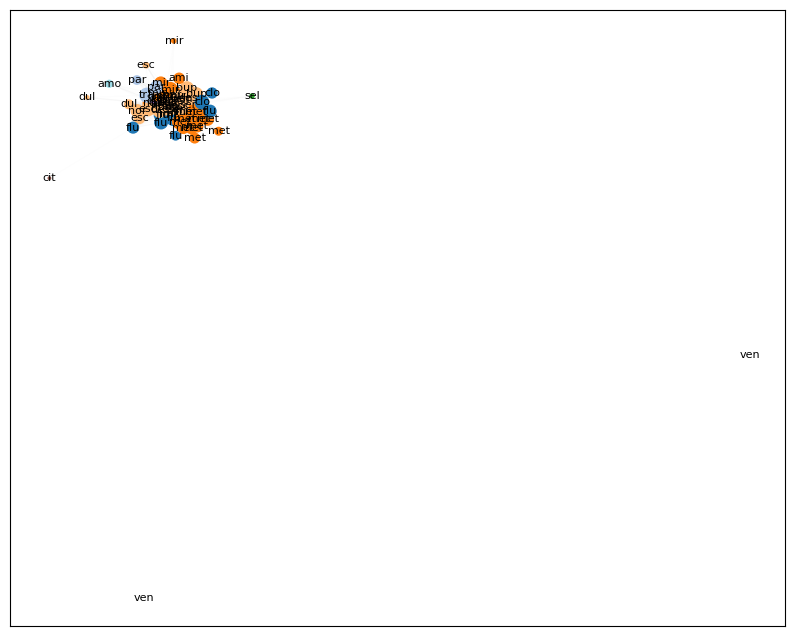

In [27]:
# 그래프를 그립니다.
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# 노드의 크기를 degree centrality에 비례하게 설정합니다.
node_size = [G.degree(node) * 3 for node in G.nodes]

# 노드의 색상을 주성분 이름의 약자에 따라 설정합니다.
encode_abbrev = {abbrev: idx for idx, abbrev in enumerate(df_mapping['주성분약자'].unique())}
node_color_by_abbrev = [encode_abbrev[mi_code_to_abbrev[node]] for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color_by_abbrev, cmap=plt.cm.tab20)

# 엣지의 투명도를 weight에 비례하게 설정합니다.
max_weight = max([d['weight'] for u, v, d in G.edges(data=True)])
for edge in G.edges(data="weight"):
    nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)

# 인덱스를 이용한 노드 레이블링을 합니다.
labels = {node: mi_code_to_abbrev[node] for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.show()

각 숫자를 해당하는 주성분에 매핑해주도록 하겠습니다.

C:\Users\YuHan\AppData\Local\Temp\ipykernel_15656\4179510509.py:4: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)


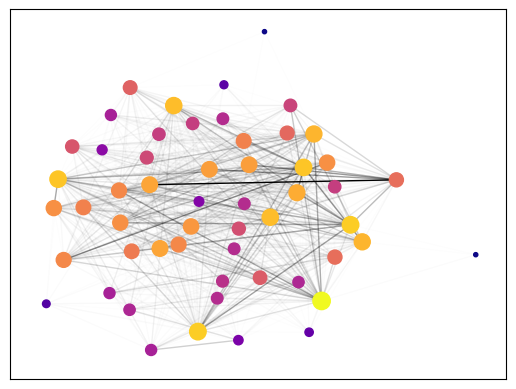

In [18]:
pos = nx.kamada_kawai_layout(G) #positions for all nodes

for edge in G.edges(data="weight"):
    nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)

nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.plasma)
plt.show()

C:\Users\YuHan\AppData\Local\Temp\ipykernel_15656\4200247507.py:4: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)


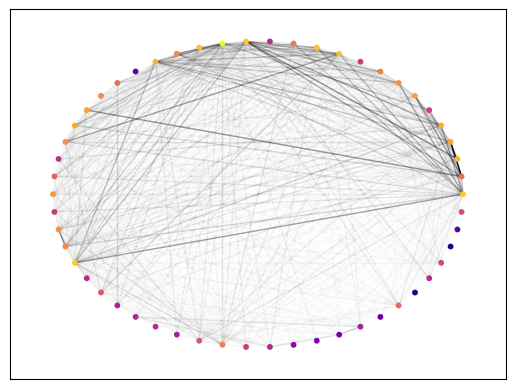

In [19]:
pos = nx.circular_layout(G) #positions for all nodes

for edge in G.edges(data="weight"):
    nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)

nx.draw_networkx_nodes(G, pos, node_size=10, node_color=node_color, cmap=plt.cm.plasma)